# ta-lib-008 ( Feature‑Engineering + Sequence Models)
https://chatgpt.com/c/680d231a-52f4-800a-a105-9f5bfe49fca1

What's new:

1-

# Load your historical Forex data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

2025-05-06 20:20:19.960865: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746550219.985087   10633 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746550219.991504   10633 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-06 20:20:20.049649: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

df = pd.read_csv('datasets/XAGUSD-H1-rates.csv', sep='\t').dropna()

# Scale selected features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>']])

# Prepare sequences
def create_sequences(features, target, window, horizon):
    X, y = [], []
    for i in range(window, len(features) - horizon):
        X.append(features[i - window:i])
        y.append(target[i:i + horizon])
    return np.array(X), np.array(y)

WINDOW_SIZE = 30
FORECAST_HORIZON = 10
X, y = create_sequences(scaled, df['<CLOSE>'].values, WINDOW_SIZE, FORECAST_HORIZON)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


# Build basic LSTM model
model = Sequential([
    LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(FORECAST_HORIZON)
])
model.compile(optimizer='adam', loss='mse')


# Train
model.fit(X_train, y_train, epochs=1, verbose=1)

# Predict and plot
y_pred = model.predict(X_test)

I0000 00:00:1746550226.825359   10633 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2275 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5
/home/saeed/repositories/machine-learning/forex-prediction/envs/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1746550229.174759   10712 cuda_dnn.cc:529] Loaded cuDNN version 90800


1377/1377 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 128.0409
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


# plot section

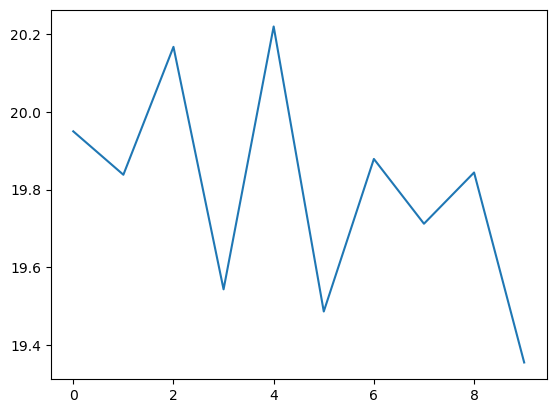

In [3]:
plt.plot(range(10), y_pred[0])
plt.show()


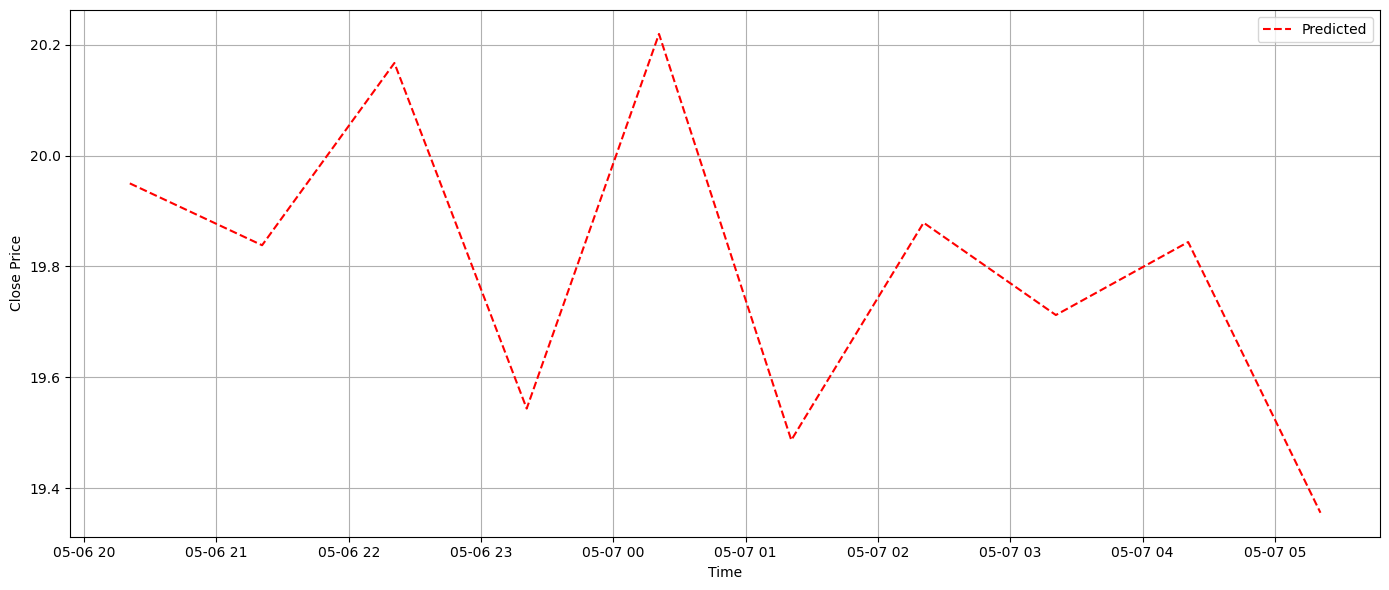

In [4]:
from utils import forex_plot_utils
from datetime import datetime

# LOAD DATA
start_time = datetime.now()

# Create datetime index starting from now, one per hour
datetime_index = pd.date_range(start=start_time, periods=len(y_pred[0]), freq='h')

# Create DataFrame
predicted_df = pd.DataFrame({'DATETIME': datetime_index, '<CLOSE>': y_pred[0]})

# PLOT
forex_plot_utils.plot_all_series(
    predicted_df=predicted_df,
)